<h1><center> Group Assignment: Bird Classifier  </center></h1>

In [1]:
# Import PyTorch and supporting libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from PIL import Image

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch

if torch.backends.mps.is_available():
    print("MPS backend is available. Running on Apple GPU.")
else:
    print("MPS backend is not available. Running on CPU.")


MPS backend is available. Running on Apple GPU.


In [3]:
device = torch.device("mps")  # Use MPS for Apple Silicon
x = torch.tensor([1.0, 2.0, 3.0], device=device)
print("Tensor on MPS:", x)

Tensor on MPS: tensor([1., 2., 3.], device='mps:0')


In [4]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Load the CSV file
# train data
train_csv_path = "data/train_images.csv"
train_label_df = pd.read_csv(train_csv_path)

# test data
test_csv_path = "data/test_images_path.csv"  # Update this path
test_label_df = pd.read_csv(test_csv_path)
# Drop the 'id' column
test_label_df = test_label_df.drop(columns=['id'])


class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with image paths and labels.
            root_dir (str): Directory containing all the images.
            transform (callable, optional): Transform to apply to the images.
        """
        self.data = pd.read_csv(csv_file)  # Read the CSV file
        self.transform = transform        # Image transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path and label
        img_path = "./data/train_images/"+self.data.iloc[idx, 0]  # Image file path
        label = self.data.iloc[idx, 1]

        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [5]:
class TestDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with image paths and labels.
            root_dir (str): Directory containing all the images.
            transform (callable, optional): Transform to apply to the images.
        """
        self.data = pd.read_csv(csv_file)  # Read the CSV file
        self.transform = transform        # Image transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path and label
        img_path = "./data/test_images/"+self.data.iloc[idx, 1]  # Image file path
        label = self.data.iloc[idx, 2]

        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [19]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import pandas as pd

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((320, 320)),  # Resize to slightly larger
    transforms.CenterCrop(299),     # Crop to 299x299
    transforms.RandomHorizontalFlip(p=0.5),      # Randomly flip images horizontally
    transforms.RandomRotation(degrees=15),        # Randomly rotate images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random adjustments
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

batch_size = 32
learning_rate = 0.0001
num_epochs = 15

# Instantiate the dataset
train_dataset = CustomDataset(csv_file=train_csv_path, transform=transform)
test_dataset = TestDataset(csv_file=test_csv_path, transform=transform)

# Get all indices and labels from the training dataset
train_dataset_size = len(train_dataset)
indices = list(range(train_dataset_size))
labels = [train_dataset[i][1] for i in indices]  # Assuming the dataset returns (image, label) tuples

# Stratified split based on the labels
train_indices, val_indices = train_test_split(indices, test_size=0.2, stratify=labels, random_state=42)

# Create Subsets
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# Create DataLoaders
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size of 1 for test dataset

# Check sizes
print(f"Train dataset size: {len(train_subset)}")
print(f"Validation dataset size: {len(val_subset)}")


Train dataset size: 3140
Validation dataset size: 786


In [20]:
# Access a batch of data
images, labels = next(iter(train_dataloader))
print("Batch of Images Shape:", images.shape)
print("Batch of Labels:", labels)

max_label = max(labels.max().item() for _, labels in train_dataloader)
print(f"Maximum label: {max_label}")

# Flatten all labels into a single tensor and compute unique classes
all_labels = []
for _, labels in train_dataloader:
    all_labels.extend(labels.numpy())  # Collect labels into a single list

num_classes = len(set(all_labels))  # Compute the number of unique classes
print(f"Number of classes: {num_classes}")

Batch of Images Shape: torch.Size([32, 3, 299, 299])
Batch of Labels: tensor([ 48,  73,  97,   3,  71,  53,  66,  12,   3,  52, 160,  25, 134,  68,
        113,  29, 144,  45,  35,   7, 135, 189, 110, 104,  28,  87,   8,  24,
         86,  18, 193,  87])
Maximum label: 200
Number of classes: 200


In [21]:
# Access a batch of data
images, labels = next(iter(val_dataloader))
print("Batch of Images Shape:", images.shape)
print("Batch of Labels:", labels)

max_label = max(labels.max().item() for _, labels in val_dataloader)
print(f"Maximum label: {max_label}")

# Flatten all labels into a single tensor and compute unique classes
all_labels = []
for _, labels in val_dataloader:
    all_labels.extend(labels.numpy())  # Collect labels into a single list

num_classes = len(set(all_labels))  # Compute the number of unique classes
print(f"Number of classes: {num_classes}")

Batch of Images Shape: torch.Size([32, 3, 299, 299])
Batch of Labels: tensor([ 70,  59,  81,  25,  85, 123,  21, 127,   7, 137, 104,  62,  10, 109,
         53,  85,  50, 151,  37, 146, 190, 145, 105,   5, 126, 184,  34,  27,
        137,  86,  16, 146])
Maximum label: 200
Number of classes: 200


In [22]:
# Iterate through the train DataLoader
for images, labels in train_dataloader:
    print(f"Batch of images: {images.shape}")  # Should be (batch_size, channels, height, width)
    print(f"Batch of labels: {labels}")       # Should match the batch_size
    break

# Iterate through the test DataLoader
for images, labels in test_dataloader:
    print(f"\nBatch of images: {images.shape}")  # Should be (batch_size, channels, height, width)
    print(f"Batch of labels: {labels}")       # Should match the batch_size
    break

Batch of images: torch.Size([32, 3, 299, 299])
Batch of labels: tensor([127,   8, 152,  39,  70,  37, 108, 110,  81, 160,  34,  15, 152,  50,
        100,  28,  36,  80,  49,  65,  46,   1,  87,  48,  12,  94, 124, 184,
        147, 150,   4,  88])

Batch of images: torch.Size([1, 3, 299, 299])
Batch of labels: tensor([1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


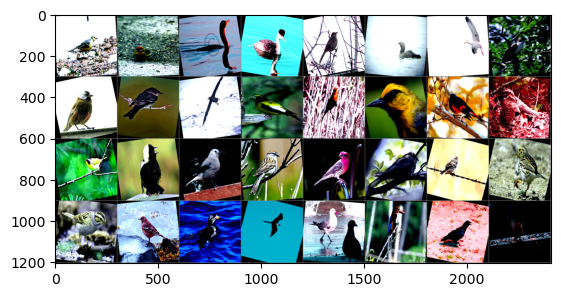

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))


In [24]:
#Step 2: Define a simple CNN model
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc = nn.Linear(16 * 64 * 64, num_classes)  # 16 channels * 64x64 image size
#         self.flatten = nn.Flatten()

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.flatten(x)
#         x = self.fc(x)
#         return x
    

# Load a pretrained ResNet model
net = models.inception_v3(pretrained=True)
net.to(device)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [25]:
# def train_and_evaluate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs):
#     model = model.to(device)
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, labels in train_dataloader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)

#             # for training inception model v3
#              # extract the output (logits)
#             logits = outputs.logits
#             loss = criterion(logits, labels)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             # for training resnet18
#             # loss = criterion(outputs, labels)
#             # loss.backward()
#             # optimizer.step()
#             running_loss += loss.item()

#         # Validation step
#         model.eval()
#         correct, total = 0, 0
#         with torch.no_grad():
#             for inputs, labels in val_dataloader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 total += labels.size(0)
#                 correct += (preds == labels).sum().item()
        
#         val_accuracy = correct / total
#         print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}, Val Accuracy: {val_accuracy}")
#     return val_accuracy

import torch

def train_and_evaluate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, scheduler):
    model = model.to(device)

    # # Freezing the layers (optional, specific for fine-tuning)
    # for param in model.parameters():
    #     param.requires_grad = False  # Freeze all parameters
    
    # # Unfreeze the last fully connected layer or a few layers if fine-tuning
    # for param in model.fc.parameters():  # Assuming 'fc' is the final fully connected layer
    #     param.requires_grad = True  # Unfreeze the final fully connected layer
    
    # If fine-tuning only a few layers
    # for param in model.conv_layers.parameters():
    #     param.requires_grad = True

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            # For InceptionV3, extract the logits
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs  # Ensure compatibility
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation step
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        val_accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Update learning rate with scheduler (if provided)
        if scheduler:
            scheduler.step()

    return val_accuracy


In [26]:
# from itertools import product

# # Define hyperparameter grid
# param_grid = {
#     'lr': [0.001, 0.01],
#     'batch_size': [16, 32],
#     'optimizer': ['SGD', 'Adam'],
#     'weight_decay': [0.0001, 0.001],
#     'momentum': [0.8, 0.9]  # Used only for SGD
# }

# # Iterate through all combinations
# best_params = None
# best_accuracy = 0
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# for lr, batch_size, optimizer_name, weight_decay, momentum in product(
#     param_grid['lr'], param_grid['batch_size'], param_grid['optimizer'], 
#     param_grid['weight_decay'], param_grid['momentum']
# ):
#     print(f"Testing combination: LR={lr}, Batch Size={batch_size}, Optimizer={optimizer_name}, WD={weight_decay}, Momentum={momentum}")

    
#     # Set optimizer
#     if optimizer_name == 'SGD':
#         optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
#     elif optimizer_name == 'Adam':
#         optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    
#     # Loss function
#     criterion = nn.CrossEntropyLoss()
    
#     # Train and evaluate
#     accuracy = train_and_evaluate(net, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=5)
    
#     # Save best params
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_params = {
#             'lr': lr,
#             'batch_size': batch_size,
#             'optimizer': optimizer_name,
#             'weight_decay': weight_decay,
#             'momentum': momentum
#         }

# print(f"Best Hyperparameters: {best_params}, Accuracy: {best_accuracy}")

In [27]:
# print(net)

# Define a loss function and optimizer
import torch.optim as optim
from torch.optim import lr_scheduler
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # would adding momentum do anything?
# optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [28]:
accuracy = train_and_evaluate(net, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, scheduler)

Epoch 1/20, Loss: 516.8475, Val Accuracy: 0.2316
Epoch 2/20, Loss: 264.9868, Val Accuracy: 0.4860
Epoch 3/20, Loss: 152.5882, Val Accuracy: 0.5407
Epoch 4/20, Loss: 95.4868, Val Accuracy: 0.5827
Epoch 5/20, Loss: 59.3608, Val Accuracy: 0.5980
Epoch 6/20, Loss: 34.6758, Val Accuracy: 0.6158
Epoch 7/20, Loss: 30.7709, Val Accuracy: 0.6260
Epoch 8/20, Loss: 26.6621, Val Accuracy: 0.6298
Epoch 9/20, Loss: 22.4012, Val Accuracy: 0.6285
Epoch 10/20, Loss: 22.6095, Val Accuracy: 0.6438
Epoch 11/20, Loss: 20.6786, Val Accuracy: 0.6374
Epoch 12/20, Loss: 19.5197, Val Accuracy: 0.6489
Epoch 13/20, Loss: 20.3594, Val Accuracy: 0.6425
Epoch 14/20, Loss: 19.8765, Val Accuracy: 0.6514
Epoch 15/20, Loss: 20.1147, Val Accuracy: 0.6603
Epoch 16/20, Loss: 19.0983, Val Accuracy: 0.6425
Epoch 17/20, Loss: 18.3705, Val Accuracy: 0.6450
Epoch 18/20, Loss: 19.5188, Val Accuracy: 0.6501
Epoch 19/20, Loss: 19.2137, Val Accuracy: 0.6438
Epoch 20/20, Loss: 18.6312, Val Accuracy: 0.6361


In [29]:
# Make a prediction on the test set

net.eval()  # Set model to evaluation mode

predictions = []

with torch.no_grad():
    for images, labels in test_dataloader:  # Assuming dataset includes image paths
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = net(images)
        
        # Get predictions (no need to subtract or add indices unless necessary)
        _, preds = torch.max(outputs, 1)
        
        # Append predictions to the list
        predictions.extend(preds.cpu().numpy())  # Convert to list and extend the predictions list
        #predictions.append((image, preds.item()))
        
        # Append original labels for analysis
        all_labels.extend(labels.cpu().tolist())  # Convert labels to list and extend

        

In [30]:
torch.save(net.state_dict(), "christinaperdue_net.pth")

In [31]:
print(all_labels) # Only to see what is inside - not needed

# Save the predictions to a CSV file
df2 = pd.DataFrame(predictions, columns=['label'])
df2.index += 1  # Shift the index to start at 1
df2.to_csv("predictions.csv", index=True, index_label='id')
print(df2.head())

[70, 59, 81, 25, 85, 123, 21, 127, 7, 137, 104, 62, 10, 109, 53, 85, 50, 151, 37, 146, 190, 145, 105, 5, 126, 184, 34, 27, 137, 86, 16, 146, 41, 118, 34, 69, 133, 15, 23, 10, 161, 4, 9, 53, 120, 133, 134, 64, 3, 45, 81, 4, 6, 60, 131, 122, 66, 62, 55, 58, 44, 141, 22, 29, 150, 4, 62, 130, 5, 163, 68, 165, 134, 175, 60, 104, 153, 71, 142, 88, 60, 74, 78, 27, 132, 100, 9, 39, 3, 80, 193, 50, 155, 65, 38, 121, 49, 120, 11, 101, 149, 118, 33, 89, 98, 37, 75, 63, 90, 19, 32, 74, 73, 41, 175, 166, 71, 23, 11, 27, 68, 54, 116, 35, 1, 182, 73, 108, 80, 43, 108, 54, 87, 97, 176, 64, 83, 72, 40, 61, 62, 124, 3, 56, 95, 70, 1, 74, 40, 59, 30, 7, 85, 183, 100, 23, 9, 99, 69, 61, 32, 36, 53, 31, 34, 48, 38, 77, 152, 53, 85, 142, 22, 65, 21, 17, 74, 23, 20, 164, 91, 49, 55, 152, 89, 57, 168, 142, 1, 76, 18, 102, 9, 16, 73, 11, 125, 8, 38, 24, 81, 7, 92, 107, 27, 147, 67, 58, 72, 79, 52, 122, 92, 42, 93, 16, 140, 63, 80, 10, 124, 87, 91, 172, 93, 19, 179, 32, 162, 26, 37, 110, 72, 33, 4, 128, 199, 45

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
/var/folders/w9/03c_s4jn509125_l99795s6c0000gn/T/ipykernel_1571/2027593376.py:16: FutureWarning: You are using `torch.load` with `weig

  0%|          | 0/1000 [00:00<?, ?it/s]

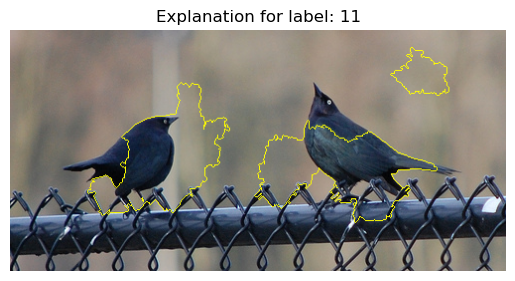

In [32]:
#LIME Setup

# Import necessary libraries
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Step 1: Load the saved model
# model = models.resnet18(pretrained=False)
# model.load_state_dict(torch.load('christinaperdue_net.pth', map_location=torch.device('cpu')))

model = models.inception_v3(pretrained=False)
model.load_state_dict(torch.load('christinaperdue_net.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

# Step 2: Define the image preprocessing pipeline
preprocess = transforms.Compose([
    # select this for resnet
    # transforms.Resize((224, 224)),  # Resize to match ResNet input size
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization

    # select this for inception
    transforms.Resize((320, 320)),  # Resize to slightly larger
    transforms.CenterCrop(299),    # Crop to 299x299
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to [-1, 1]
])



# Step 3: Load and preprocess the image
#431
test_image_path = 'data/test_images/test_images/493.jpg'
image = Image.open(test_image_path).convert('RGB')
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

# Step 4: Define the prediction function
def predict_function(images):
    """
    LIME expects a NumPy array as input.
    This function converts images back to PyTorch tensors, predicts, and outputs probabilities.
    """
    images = torch.tensor(images).permute(0, 3, 1, 2)  # Convert to (batch, channels, height, width)
    images = images.float() / 255  # Scale pixel values to [0, 1]
    
    # Normalize images like in preprocessing
    for i in range(images.shape[0]):
        images[i] = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(images[i])
    
    with torch.no_grad():
        outputs = model(images)  # Get logits
        probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Convert to probabilities
    return probabilities.numpy()

# Step 5: Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Step 6: Generate explanation
explanation = explainer.explain_instance(
    np.array(image),  # Pass the image as a NumPy array
    predict_function,  # The prediction function
    top_labels=5,  # Number of top labels to explain
    hide_color=0,  # Hide regions with zero color
    num_samples=1000  # Number of perturbed samples
)

# Step 7: Visualize the explanation
from matplotlib import pyplot as plt

# Choose the label to visualize
label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Display the explanation
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"Explanation for label: {label}")
plt.axis('off')
plt.show()